### 2. Data splitting, augmentation, and cropping

Before we train any ML model on our data (ACRIMA dataset), we will first split the data into training & validation sets which can later be augmented using keras' `ImageDataGenerator` method. Also, we will preprocess the images from the Kaggle dataset before running the evaluation of the models.

#### 2.1. Train-validation split

In [ ]:
import os
import shutil
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Get the current working directory
current_dir = os.getcwd()

# Create new directories to separate the train & validation datasets
acrima_dir = os.path.join(current_dir, "data/acrima-dataset")
new_directories = ["train", "validation"]
new_subdirectories = ["glaucoma", "normal"]

for directory in new_directories:
    new_directory_path = os.path.join(acrima_dir, directory)
    if os.path.isdir(new_directory_path) == False:
        os.makedirs(new_directory_path)

    for subdirectory in new_subdirectories:
        new_subdirectory_path = os.path.join(new_directory_path, subdirectory)
        if os.path.isdir(new_subdirectory_path) == False:
            os.makedirs(new_subdirectory_path)

In [ ]:
# Create function to split data from glaucoma & normal folders
def split_data(source_dir, train_dir, val_dir, split_size):
    source_files = os.listdir(source_dir)

    # Ensure there are non-empty files
    files_to_copy = []

    for file_path in source_files:
        if os.path.getsize(os.path.join(source_dir, file_path)) > 0:
            files_to_copy.append(file_path)

    # Shuffle the files in the list for further random selection
    files_to_copy = random.sample(files_to_copy, len(files_to_copy))

    # Remove previous files from training & validation folders
    for file_path in os.listdir(train_dir):
        os.remove(os.path.join(train_dir, file_path))

    for file_path in os.listdir(val_dir):
        os.remove(os.path.join(val_dir, file_path))

    # Copy files to the training & validation set
    training_size = int(split_size * len(files_to_copy))
    for i in range(0, training_size):
        source_path = os.path.join(source_dir, files_to_copy[i])
        destination_path = os.path.join(train_dir, files_to_copy[i])
        shutil.copyfile(source_path, destination_path) 

    for i in range(training_size, len(files_to_copy)):
        source_path = os.path.join(source_dir, files_to_copy[i])
        destination_path = os.path.join(val_dir, files_to_copy[i])
        shutil.copyfile(source_path, destination_path) 

In [ ]:
# Copy the glaucoma files into the train & validation datasets
glaucoma_dir = os.path.join(acrima_dir, "glaucoma")
glaucoma_train_dir = os.path.join(acrima_dir, "train/glaucoma")
glaucoma_val_dir = os.path.join(acrima_dir, "validation/glaucoma")

# We will use a 80% split size initially
split_size = 0.8
split_data(glaucoma_dir, glaucoma_train_dir, glaucoma_val_dir, split_size=split_size)

In [ ]:
# Copy the normal files into the train & validation datasets
normal_dir = os.path.join(acrima_dir, "normal")
normal_train_dir = os.path.join(acrima_dir, "train/normal")
normal_val_dir = os.path.join(acrima_dir, "validation/normal")

# We'll use the same split size
split_data(normal_dir, normal_train_dir, normal_val_dir, split_size=split_size)

#### 2.2. Image augmentation

In [ ]:
# Create image generators for the training & validation data
def image_generators(train_dir, val_dir, train_img_size, val_img_size):
  """
  Inputs:
  train_dir = training data directory
  val_dir = validation data directory
  train_img_size = the size of the training input images (tuple)
  val_img_size = the size of the validation input images (tuple)

  Outputs:
  train_generator = image generator for training data
  val_generator = image generator for validation data
  """

  # Instatiate ImageGenerator & rescale
  train_datagen = ImageDataGenerator(rescale=1./255)
  val_datagen = ImageDataGenerator(rescale=1./255)

  # Apply the ImageGenerator to the training & validation datasets
  train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                      batch_size=20,
                                                      class_mode='binary',
                                                      target_size=train_img_size)

  val_generator = val_datagen.flow_from_directory(directory=val_dir,
                                                                batch_size=20,
                                                                class_mode='binary',
                                                                target_size=val_img_size)
  
  return train_generator, val_generator

These functions are also saved in `utils.py` for use in later notebooks.

#### 2.3. Testing data preprocessing

Given that evaluation on the full-sized retinal fundus images in the kaggle dataset yielded poor results both with the simple and more complex deep learning models, we will crop the images before re-evaluating them.

To do so, we employ a cropping function from [Huazhu Fu's repository](https://github.com/HzFu/MNet_DeepCDR) from a paper on optic disc & cup segmentation[$^{[1]}$](https://arxiv.org/abs/1801.00926), which is based on a U-Net architecture trained to detect the optical disc.

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
# Code taken and adapted from optic disc / cup segmentation paper
from __future__ import print_function

from os import path
from sys import modules

import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from pkg_resources import resource_filename
from skimage.measure import label, regionprops
from skimage.transform import rotate, resize
from tensorflow.keras.preprocessing import image

from cropping_scripts import Model_DiscSeg as DiscModel
from cropping_scripts.mnet_utils import BW_img, disc_crop, mk_dir, files_with_ext

In [22]:
data_type = '.png'
parent_dir = "drive/MyDrive"
g_data_img_path = path.abspath(path.join(parent_dir, 'kaggle_dataset', 'glaucoma'))
g_data_save_path = mk_dir(path.join(parent_dir, 'training_crop', 'glaucoma'))
n_data_img_path = path.abspath(path.join(parent_dir, 'kaggle_dataset', 'normal'))
n_data_save_path = mk_dir(path.join(parent_dir, 'training_crop', 'normal'))

In [23]:
# Adapt the optic disc segmentation code to current problem
def crop_images(parent_dir, data_img_path, data_save_path, data_type='.png', disc_list=[400, 500, 600, 700, 800], \
                DiscROI_size=800, DiscSeg_size=640, CDRSeg_size=400):
  
  file_test_list = files_with_ext(data_img_path, data_type)

  # Load segmentation model
  DiscSeg_model = DiscModel.DeepModel(size_set=DiscSeg_size)
  DiscSeg_model.load_weights(path.join(parent_dir, 'deep_model', 'Model_DiscSeg_ORIGA.h5'))

  for lineIdx, temp_txt in enumerate(file_test_list):

      # Show preprocessing progress
      print('Processing Img {idx}: {temp_txt}'.format(idx=lineIdx + 1, temp_txt=temp_txt))

      # Load image
      org_img = np.asarray(image.load_img(path.join(data_img_path, temp_txt)))

      # Disc region detection by U-Net
      temp_img = resize(org_img, (DiscSeg_size, DiscSeg_size, 3)) * 255
      temp_img = np.reshape(temp_img, (1,) + temp_img.shape)
      disc_map = DiscSeg_model.predict([temp_img])
      disc_map = BW_img(np.reshape(disc_map, (DiscSeg_size, DiscSeg_size)), 0.5)
      regions = regionprops(label(disc_map))
      C_x = int(regions[0].centroid[0] * org_img.shape[0] / DiscSeg_size)
      C_y = int(regions[0].centroid[1] * org_img.shape[1] / DiscSeg_size)

      for disc_idx, DiscROI_size in enumerate(disc_list):
          disc_region, err_coord, crop_coord = disc_crop(org_img, DiscROI_size, C_x, C_y)
          disc_result = Image.fromarray((disc_region).astype(np.uint8))
          filename = '{}_{}.png'.format(temp_txt[:-4], DiscROI_size)
          disc_result.save(path.join(data_save_path, filename))

  plt.imshow(disc_result)
  plt.show()

In [ ]:
crop_images(parent_dir, g_data_img_path, g_data_save_path, disc_list=[600])

300
Processing Img 1: NL_001.png
Processing Img 2: NL_002.png
Processing Img 3: NL_003.png
Processing Img 4: NL_004.png
Processing Img 5: NL_005.png
Processing Img 6: NL_006.png
Processing Img 7: NL_007.png
Processing Img 8: NL_008.png
Processing Img 9: NL_009.png
Processing Img 10: NL_011.png
Processing Img 11: NL_012.png
Processing Img 12: NL_010.png
Processing Img 13: NL_016.png
Processing Img 14: NL_013.png
Processing Img 15: NL_017.png
Processing Img 16: NL_018.png
Processing Img 17: NL_015.png
Processing Img 18: NL_014.png
Processing Img 19: NL_025.png
Processing Img 20: NL_021.png
Processing Img 21: NL_020.png
Processing Img 22: NL_023.png
Processing Img 23: NL_019.png
Processing Img 24: NL_024.png
Processing Img 25: NL_022.png
Processing Img 26: NL_027.png
Processing Img 27: NL_029.png
Processing Img 28: NL_026.png
Processing Img 29: NL_028.png
Processing Img 30: NL_030.png
Processing Img 31: NL_034.png
Processing Img 32: NL_037.png
Processing Img 33: NL_035.png
Processing Img 

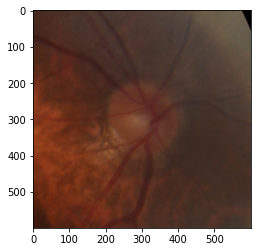

In [24]:
crop_images(parent_dir, n_data_img_path, n_data_save_path, disc_list=[600])

#### 2.4. References

[1] Huazhu Fu, Jun Cheng, Yanwu Xu, Damon Wing Kee Wong, Jiang Liu, and Xiaochun Cao, "Joint Optic Disc and Cup Segmentation Based on Multi-label Deep Network and Polar Transformation", IEEE Transactions on Medical Imaging (TMI), vol. 37, no. 7, pp. 1597–1605, 2018. [PDF](https://arxiv.org/abs/1801.00926)